In [9]:
#!py -m pip install SimpleITK

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from my_img_processor import My_Image
import matplotlib as mpl

In [11]:
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')

Leemos la imagen cruda

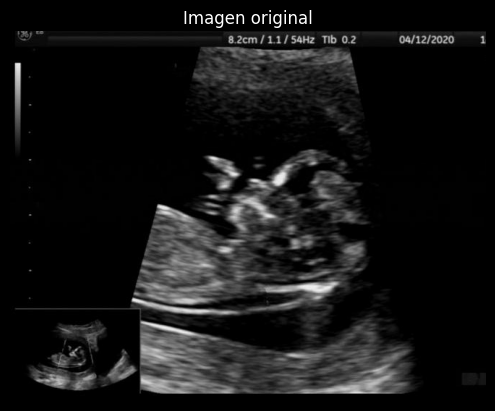

In [12]:
img_path = r'Dataset for Fetus Framework\Dataset for Fetus Framework\External Test Set\Standard\1383.png'
raw_img = My_Image(img_path)

fig_raw, ax_raw = plt.subplots()
ax_raw.imshow(raw_img, vmin=0, vmax=255, cmap='gray')
ax_raw.set_title('Imagen original')
plt.axis('off')
plt.show()

Definimos una función para elegir el punto inicial

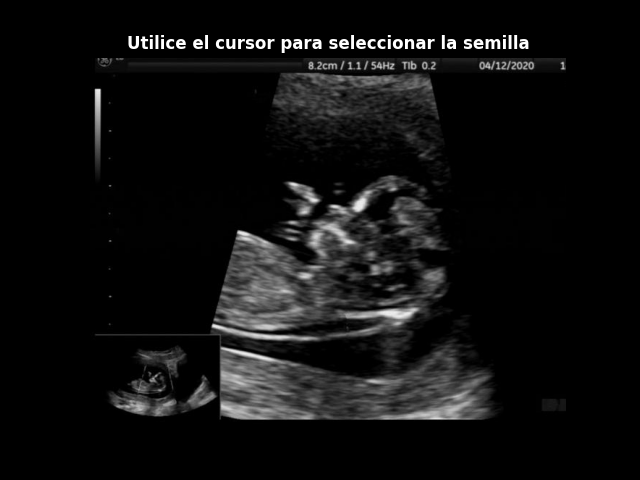

In [13]:
%matplotlib widget
x, y = 330, 370
def interactive_plot(img):
   plt.ion()
   fig, ax = plt.subplots()
   fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)
   ax.set_title('Utilice el cursor para seleccionar la semilla', fontweight='bold')
   def onclick(event):
      global x
      global y
      x = int(np.ceil(event.xdata))
      y = int(np.ceil(event.ydata))
      print(f"{x=}, {y=}")
      ax.plot(x, y, marker='x', color='yellow')
      ax.figure.canvas.draw()
      fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)

   ax.imshow(img, vmin=0, vmax=255, cmap='gray')
   plt.axis(False)
   fig.canvas.mpl_connect('button_press_event', onclick)
   plt.show()
   plt.ioff()

interactive_plot(raw_img)

In [14]:
plt.close()
%matplotlib inline

No such comm: bd69cb552c9a41e68ffe8c46a835ce05


Ecualizamos el histograma

In [15]:
eq_img = raw_img.equalize_hist()

Binarizamos con el punto medio del histograma ecualizado

In [16]:
bin_img = np.zeros_like(raw_img)
THRES = 255//2
for i in range(bin_img.shape[0]):
    for j in range(bin_img.shape[1]):
        if eq_img[i, j] > THRES:
            bin_img[i, j] = 255

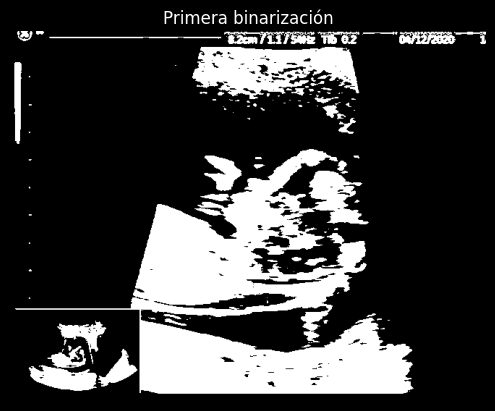

In [17]:
fig_bin, ax_bin = plt.subplots()
ax_bin.imshow(bin_img, vmin=0, vmax=255, cmap='gray')
ax_bin.set_title('Primera binarización')
plt.axis(False)
plt.show()

Eliminamos el ruido de sal y pimienta que surge de esta binarización

In [18]:
sp_img = bin_img.median_filter(5)

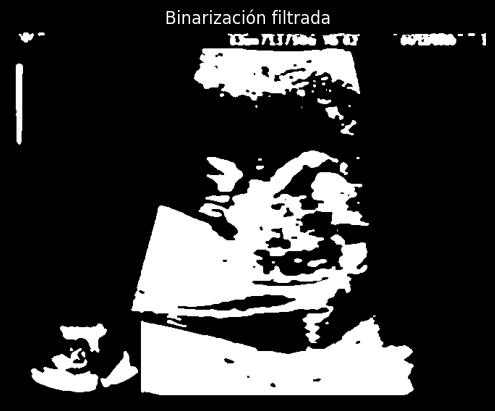

In [19]:
fig_sp, ax_sp = plt.subplots()
ax_sp.imshow(sp_img, vmin=0, vmax=255, cmap='gray')
ax_sp.set_title('Binarización filtrada')
plt.axis(False)
plt.show()

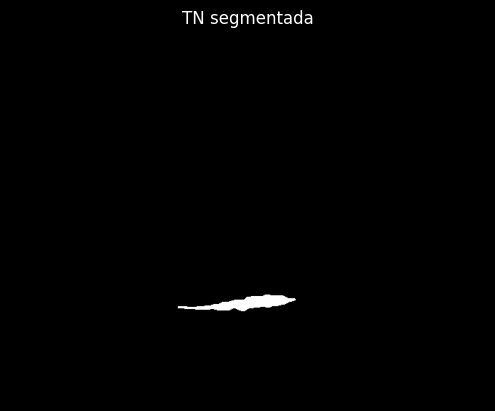

In [20]:
img_sitk = sitk.GetImageFromArray(sp_img)
img_seg = sitk.ConnectedThreshold(img_sitk, seedList=[(x, y)])
img_seg = My_Image(sitk.GetArrayFromImage(img_seg))

fig_seg, ax_seg = plt.subplots()
ax_seg.imshow(img_seg, vmin=0, vmax=1, cmap='gray')
ax_seg.set_title('TN segmentada')
plt.axis(False)
plt.show()

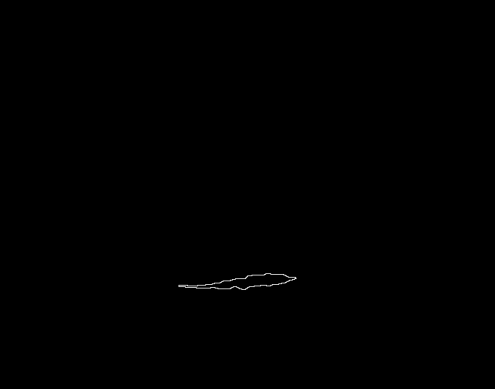

In [21]:
img_seg[img_seg > 0] = 255
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg = img_seg.filter_w_kernel(KL1)
plt.imshow(border_seg, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

Extraemos los puntos del borde

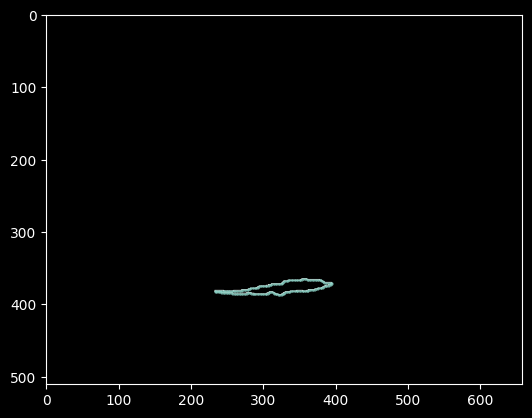

In [22]:
Y, X = border_seg.nonzero()

fig, ax = plt.subplots()
ax.imshow(border_seg, vmin=0, vmax=255, cmap='gray')
ax.scatter(X, Y, s=0.1)
plt.show()

Fitteamos una elipe

In [23]:
A = np.array([X**2, X * Y, Y**2, X, Y]).T
b = np.ones_like(X)
p = np.linalg.lstsq(A, b)[0].squeeze()
p

C:\Users\gonza\AppData\Local\Temp\ipykernel_13064\479152165.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(A, b)[0].squeeze()


array([-9.59840754e-08, -1.18355142e-06, -5.94620903e-06,  5.09208149e-04,
        4.86753108e-03])

Calculamos los parámetros canónicos de la elipse

In [24]:
A = p[0]
B = p[1]
C = p[2]
D = p[3]
E = p[4]
F = -1

Q = 64*((F*(4*A*C - B**2) - A*E**2 + B*D*E - C*D**2)/(4*A*C - B**2)**2)
S = (1/4)*np.sqrt(np.abs(Q)*np.sqrt(B**2 + (A-C)**2))
R_max = (1/8)*np.sqrt(2*np.abs(Q)*np.sqrt(B**2 + (A-C)**2) - 2*Q*(A+C))
R_min = np.sqrt(R_max**2 - S**2)
X_c = (B*E - 2*C*D)/(4*A*C - B**2)
Y_c = (B*D - 2*A*E)/(4*A*C - B**2)

qa = Q*A
qc = Q*C
qb = Q*B

if qa - qc == 0 and qb == 0:
    angle = 0

elif qa - qc == 0 and qb > 0:
    angle = np.pi/4

elif qa - qc == 0 and qb < 0:
    angle = 3*np.pi/4

elif qa - qc > 0 and qb >= 0:
    angle = 0.5*np.arctan(B/(A-C))

elif qa - qc > 0 and qb < 0:
    angle = 0.5*np.arctan(B/(A-C))+np.pi

elif qa - qc < 0:
    angle = 0.4*np.arctan(B/(A-C))+0.5*np.pi


In [34]:
c = 38/5
c

7.6

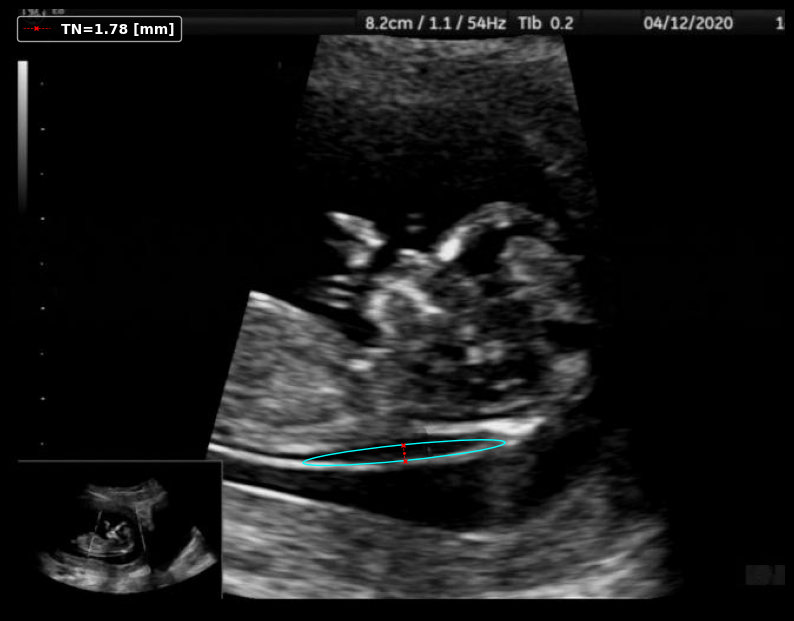

In [35]:
ellipse_patch = mpl.patches.Ellipse(xy=(X_c, Y_c),
                                    width=2*R_max,
                                    height=2*R_min,
                                    angle=180*angle/np.pi,
                                    linestyle='-',
                                    edgecolor='cyan',
                                    fill=False)


center = np.array([X_c, Y_c])
offset_point = np.array([R_min*np.cos(angle + np.pi/2), R_min*np.sin(angle + np.pi/2)])
TN_topmark = center + offset_point
TN_botmark = center - offset_point

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(raw_img, vmin=0, vmax=255, cmap='gray')
ax.add_patch(ellipse_patch)
ax.plot(X_c, Y_c, 'ro', markersize=1)
ax.plot([TN_topmark[0], TN_botmark[0]], [TN_topmark[1], TN_botmark[1]], 
        linestyle='--', 
        color='red',
        marker='x',
        markersize=3,
        linewidth=0.5,
        label=f"TN={2*R_min/c:.2f} [mm]")

plt.legend(loc='upper left', fontsize='big', prop={'weight':'bold'})
plt.axis('off')
plt.show()